# Land Cover Change - Desertification
Change in land cover class (as defined by [Copernicus Global Land Cover](https://lcviewer.vito.be/about)): natural land turning into bare ground. Disaggregated by original type/grouping: Forest, Other Vegetation, Wetland, Cropland.  

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.

_Author: Peter Kerins_  
_Created: 11 Jun 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Stacked bar

## Data
Surface areas [calculated on Google Earth Engine](https://code.earthengine.google.com/1a106a75689826e6bf7283b7d7c7f6f5); outputs combined and restructured via [Python script](../analysis/land-cover-change-structuring.py).  
Carto: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all country widgets on Ocean Watch)    

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

# Widget

## Demo Query
`gid_0 ILIKE <iso3>` used as stand-in for parameterized `geostore_id={{geostore_id}}` in production version
```sql
SELECT gid_0, name_0, variable, date, value, unit 
FROM ow_widget_territory
WHERE widget ILIKE 'land cover change: desertification'
AND gid_0 ILIKE 'BRA'
ORDER BY gid_0 ASC, date ASC, variable DESC
```

## Parameterized Query
```sql
SELECT territory.gid_0, territory.name_0, territory.variable, territory.date, territory.value 
FROM ow_widget_territory territory
LEFT OUTER JOIN gadm36_0 gadm ON territory.gid_0 = gadm.gid_0
WHERE territory.widget ILIKE 'land cover change: desertification'
AND gadm.gid_0 ILIKE '{{geostore_id}}'
ORDER BY territory.gid_0 ASC, territory.date ASC, territory.variable DESC
```

## Specification
Code presented in notebook is already written for RW (rather than standard Vega). This does not extent to parameterization.

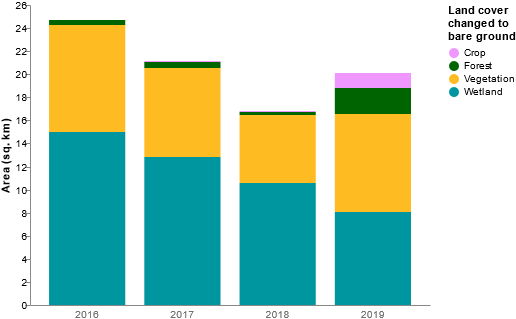

In [4]:
spec=json.loads("""
{
  "width": 300,
  "height": 300,
  "autosize": {"type": "pad", "resize": true, "contains": "padding"},
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, name_0, variable, date, value, unit FROM ow_widget_territory WHERE widget ILIKE %27land cover change: desertification%27 AND gid_0 ILIKE %27BRA%27 ORDER BY gid_0 ASC, date ASC, variable DESC",
      "format": {
        "type": "json", "property": "rows"
      },
      "transform": [
        {
          "type": "stack",
          "groupby": ["gid_0","date"],
          "field": "value"
        },
        {
          "type": "formula",
          "expr": "(datum.variable=='cropBare' ? 'Crop' : (datum.variable=='forestBare' ? 'Forest' : (datum.variable=='vegBare' ? 'Vegetation' : 'Wetland')))",
          "as": "alias"
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "date"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {"data": "table", "field": "y1"},
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": [
        "Crop",
        "Forest",
        "Vegetation",
        "Wetland"
      ],
      "range": [
        "#F096FF",
        "#006400",
        "#FFBB22",
        "#0096A0"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Area (sq. km)",
      "encode": {
        "labels": {
          "interactive": true,
          "enter": {
          },
          "update": {
            "align": {"value": "right"},
            "baseline": {"value": "middle"},
            "dx": {"value": 4},
            "fill": {"value": "#717171"}
          },
          "hover": {"fill": {"value": "firebrick"}}
        }
      }
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": true,
          "enter": {
          },
          "update": {
            "fill": {"value": "#717171"}
          },
          "hover": {
            "fill": {
              "value": "black"
            }
          }
        }
      }
    }
  ],
  "marks": [
    {
      "name": "bars",
      "from": {"data": "table"},
      "type": "rect",
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "date"},
          "width": {"scale": "xscale", "band": 1},
          "y": {"scale": "yscale", "field": "y0"},
          "y2": {"scale": "yscale", "field": "y1"},
          "fill": {"scale": "color", "field": "alias"}
        },
        "hover": {"fillOpacity": {"value": 0.5}},
        "update": {"fillOpacity": {"value": 1}}
      }
    }
  ],
  "legends": [
    {
      "title": ["Land cover", "changed to", "bare ground"],
      "fill": "color",
      "orient": "right"
    }
  ],
  "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "alias",
            "property": "Land cover type",
            "type": "string"
          },
          {
            "column": "value",
            "property": "Area (sq. km)",
            "type": "number",
            "format": ",.1f"
          }
        ]
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# RW API
Parent dataset [soc.104.rw0 Global Land Cover](https://resourcewatch.org/data/explore/Global-Land-Cover-UN-FAO-LCCS-Classification) ([Admin](https://resourcewatch.org/admin/data/datasets/b2f00f99-46ed-43e6-a7a1-a5809d9369d4/edit))    
[API ID](https://api.resourcewatch.org/v1/dataset/b2f00f99-46ed-43e6-a7a1-a5809d9369d4/) `b2f00f99-46ed-43e6-a7a1-a5809d9369d4`  
[Widgets](https://api.resourcewatch.org/v1/dataset/b2f00f99-46ed-43e6-a7a1-a5809d9369d4/widget)

Widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

## Demo: Brazil

In [2]:
dataset_id = 'b2f00f99-46ed-43e6-a7a1-a5809d9369d4'
name = 'Land Cover Change in Brazil, 2015–2019: Desertification'
description = 'Area of land that transitioned to bare ground, year on year and disaggregated by starting land cover type'

- [Brazil](https://api.resourcewatch.org/v1/widget/a0663e71-5645-4bbe-9801-e91914c0a167?env=production) `a0663e71-5645-4bbe-9801-e91914c0a167`  

## Parameterized Version

In [2]:
dataset_id = 'b2f00f99-46ed-43e6-a7a1-a5809d9369d4'
name = 'Desertification, 2015–2019'
description = 'Area of land that transitioned to bare ground, year on year and disaggregated by starting land cover type'

- [Country Page](https://api.resourcewatch.org/v1/widget/bd2e07f0-f62a-42df-83e6-65a3ebcdbc29?env=production) `bd2e07f0-f62a-42df-83e6-65a3ebcdbc29`  